In [18]:

# Libraries & Load Data

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("data/water_potability.csv")

# Inspect data
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [19]:

#  Handle Missing Values

df = df.dropna().reset_index(drop=True)

# Features (exclude target if present)
X = df.drop(columns=["Potability"], errors='ignore')

In [20]:

#  Scale Features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:

#  PCA Before Clustering
pca = PCA(n_components=0.9, random_state=0)
X_pca_reduced = pca.fit_transform(X_scaled)
print(f"Original features: {X_scaled.shape[1]}, Reduced features: {X_pca_reduced.shape[1]}")

Original features: 9, Reduced features: 8


Best k according to Elbow Method: 3
Best k according to Silhouette Score: 2
Best k according to Calinski-Harabasz Index: 2


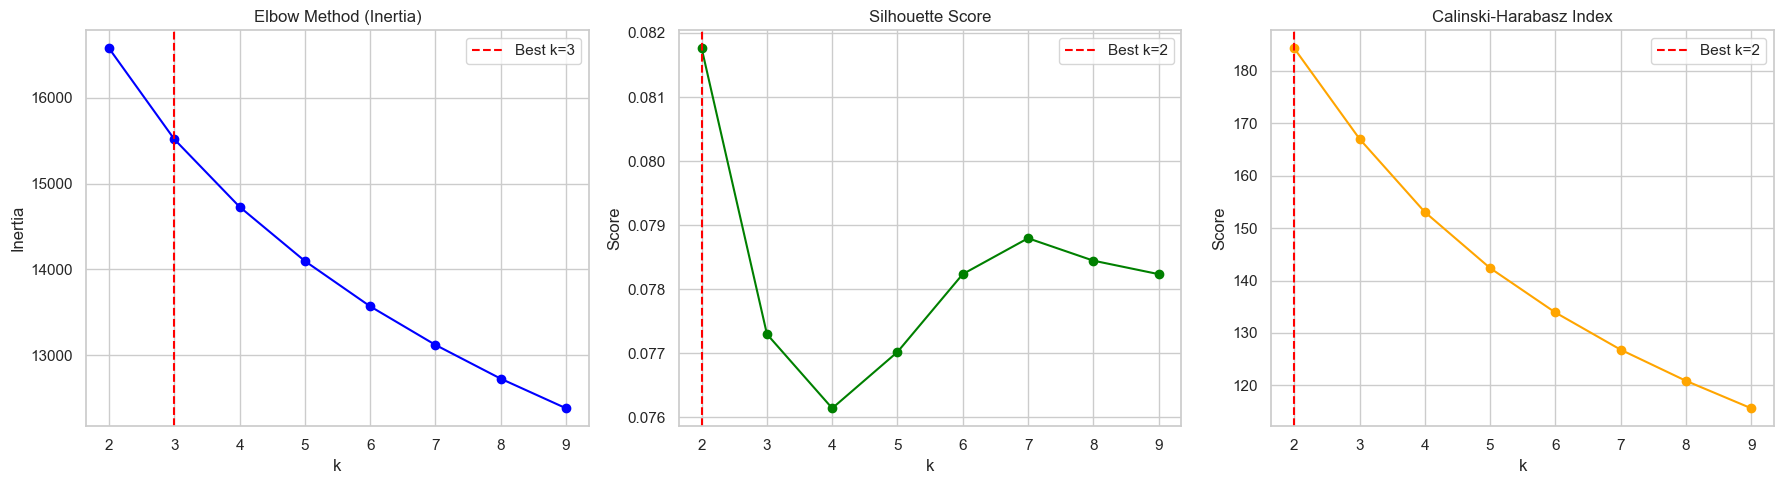

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Range of k values to test
k_range = range(2, 10)

# Lists to store metrics
inertias = []
sil_scores = []
ch_scores = []

# Compute metrics
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=50)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# Determine best k for each metric
inertia_drops = [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
best_k_elbow = k_range[inertia_drops.index(max(inertia_drops)) + 1]
best_k_silhouette = k_range[sil_scores.index(max(sil_scores))]
best_k_ch = k_range[ch_scores.index(max(ch_scores))]

print("Best k according to Elbow Method:", best_k_elbow)
print("Best k according to Silhouette Score:", best_k_silhouette)
print("Best k according to Calinski-Harabasz Index:", best_k_ch)

# Optional: put metrics in a DataFrame
comparison_df = pd.DataFrame({
    "k": list(k_range),
    "Inertia": inertias,
    "Silhouette": sil_scores,
    "Calinski-Harabasz": ch_scores
})


plt.figure(figsize=(18,5))

# Inertia (Elbow)
plt.subplot(1,3,1)
plt.plot(k_range, inertias, marker='o', color='blue')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.axvline(best_k_elbow, color='red', linestyle='--', label=f"Best k={best_k_elbow}")
plt.legend()

# Silhouette
plt.subplot(1,3,2)
plt.plot(k_range, sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.axvline(best_k_silhouette, color='red', linestyle='--', label=f"Best k={best_k_silhouette}")
plt.legend()

# Calinski-Harabasz
plt.subplot(1,3,3)
plt.plot(k_range, ch_scores, marker='o', color='orange')
plt.title("Calinski-Harabasz Index")
plt.xlabel("k")
plt.ylabel("Score")
plt.axvline(best_k_ch, color='red', linestyle='--', label=f"Best k={best_k_ch}")
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
# K-means with 2 clusters (best k from metrics)
k_final = 2
kmeans = KMeans(n_clusters=k_final, random_state=0, n_init=50)
clusters = kmeans.fit_predict(X_pca_reduced ) 

# Add cluster labels
df["Cluster"] = clusters



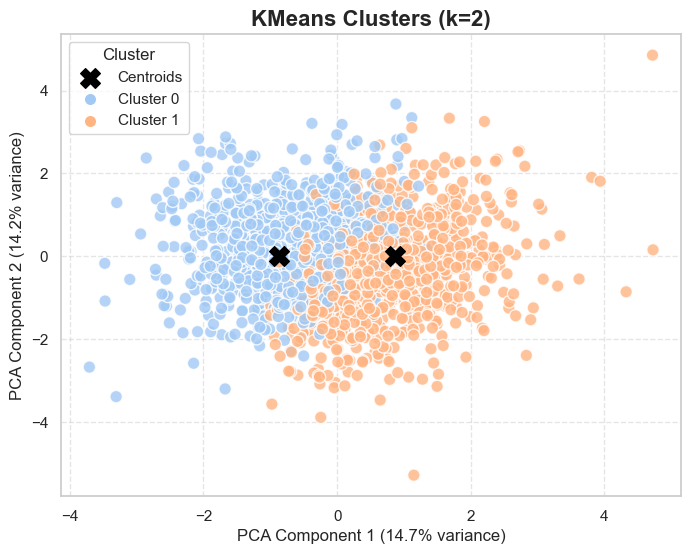

Graph saved at: ../results/graphs\KMeans_2_Clusters_PCA.png


In [25]:

#  2D PCA Visualization

# PCA for 2D plot
X_plot = PCA(n_components=2, random_state=0).fit_transform(X_pca_reduced)
explained_var = PCA(n_components=2).fit(X_pca_reduced).explained_variance_ratio_ * 100


cluster_labels = df["Cluster"].unique()
palette = sns.color_palette("pastel", n_colors=len(cluster_labels))
colors = [palette[label] for label in df["Cluster"]]

plt.figure(figsize=(8,6))
plt.scatter(
    X_plot[:,0],
    X_plot[:,1],
    c=colors,
    s=80,
    alpha=0.8,
    edgecolor='w'
)

# Plot centroids
centroids_2d = PCA(n_components=2, random_state=0).fit_transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], s=200, c='black', marker='X', label='Centroids')

plt.title(f"KMeans Clusters (k={k_final})", fontsize=16, weight='bold')
plt.xlabel(f"PCA Component 1 ({explained_var[0]:.1f}% variance)")
plt.ylabel(f"PCA Component 2 ({explained_var[1]:.1f}% variance)")


for i, label in enumerate(cluster_labels):
    plt.scatter([], [], color=palette[i], label=f"Cluster {label}", s=80, edgecolor='w')
plt.legend(title="Cluster", loc="best")

plt.grid(True, linestyle='--', alpha=0.5)

# Save figure
folder_path = "../results/graphs"
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, f"KMeans_{k_final}_Clusters_PCA.png")
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Graph saved at: {file_path}")

In [26]:

#  Cluster Summary

cluster_summary = df.groupby("Cluster").mean()
display(cluster_summary)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
Cluster,,,,,,,,,,
0,7.731577,210.381955,18054.393456,7.009974,342.165832,423.261524,15.032870,62.016718,3.797165,0.383603
1,6.462490,182.047332,25648.322453,7.254448,324.589416,429.679592,13.705648,70.635005,4.136389,0.422287


Confusion matrix:
 [[609 591]
 [379 432]]

Purity: 0.5967180507210343

Cluster composition:
 Potability    0    1
Cluster             
0           609  379
1           591  432


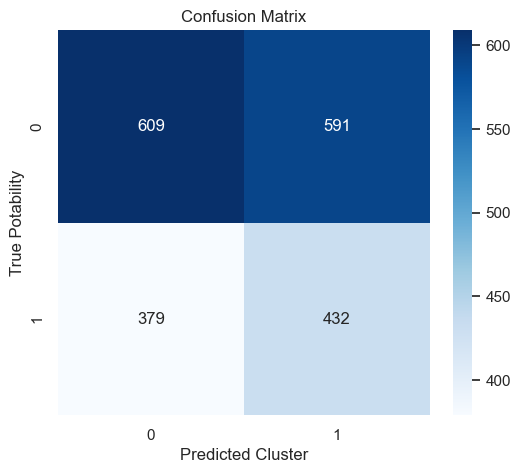

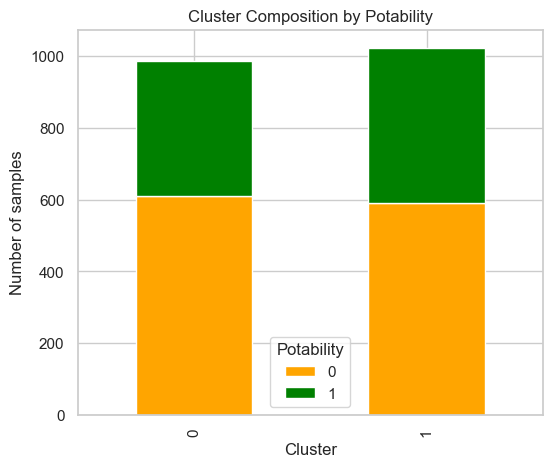

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_true = df["Potability"]  # actual potability labels
y_pred = df["Cluster"]     # cluster labels from KMeans or GMM

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


# Purity calculation
# Purity = sum of the largest class in each cluster / total samples
correct = np.sum(np.max(cm, axis=0))
total = np.sum(cm)
purity = correct / total
print("\nPurity:", purity)


# Cluster composition summary

summary = df.groupby("Cluster")["Potability"].value_counts().unstack().fillna(0)
print("\nCluster composition:\n", summary)

#  Confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Potability')
plt.title('Confusion Matrix')
plt.show()

# Cluster composition bar plot
summary.plot(kind='bar', stacked=True, figsize=(6,5), color=['orange','green'])
plt.xlabel('Cluster')
plt.ylabel('Number of samples')
plt.title('Cluster Composition by Potability')
plt.legend(title='Potability')
plt.show()
